In [41]:
import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import csv

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

%load_ext autoreload
%autoreload 2
%matplotlib inline

from helpers import calculate_mse

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 0.1 Load and prepare data

### Training and testing data

#### Load the Data
`ratings` is a sparse matrix in the shape of (num_items, num_users)

In [42]:
from helpers import load_data, preprocess_data

DATA_PATH = '../data/'
PREDICTION_PATH = '../data/predictions/'
ratings = load_data('{dp}data_train.csv'.format(dp=DATA_PATH))
#ratings = load_data('{dp}movielens100k.csv'.format(dp=DATA_PATH))

number of items: 10000, number of users: 1000


#### Plot the number of ratings per movie and user

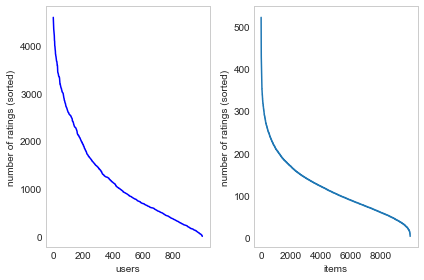

min # of items per user = 8, min # of users per item = 3.


In [43]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

#### Split the data into a train and test set

In [44]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1, verbose=False):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][:, valid_users]
    
    # LIL is a convenient format for constructing sparse matrices
    train = sp.lil_matrix(valid_ratings.shape)
    test = sp.lil_matrix(valid_ratings.shape)
    
    valid_ratings_i, valid_ratings_u, valid_ratings_v = sp.find(valid_ratings)
    valid_ratings_p_idx = np.random.permutation(range(len(valid_ratings_i)))
    
    n_test = int(p_test*len(valid_ratings_i))
    
    for idx in valid_ratings_p_idx[:n_test]:
        test[valid_ratings_i[idx], valid_ratings_u[idx]] = valid_ratings_v[idx]
        
    for idx in valid_ratings_p_idx[n_test:]:
        train[valid_ratings_i[idx], valid_ratings_u[idx]] = valid_ratings_v[idx]

    if verbose:
        print("Total number of nonzero elements in original data:{v}".format(v=ratings.nnz))
        print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
        print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    
    # convert to CSR for faster operations
    return valid_ratings, train.tocsr(), test.tocsr()

In [66]:
valid_ratings, train, test = split_data(ratings, num_items_per_user,
    num_users_per_item, min_num_ratings=10, p_test=0.1, verbose=True)

Total number of nonzero elements in original data:1176952
Total number of nonzero elements in train data:1059186
Total number of nonzero elements in test data:117687


### Read submission creation data

In [67]:
ratings_csr = ratings.tocsr()
sample_submission = load_data('{dp}sample_submission.csv'.format(dp=DATA_PATH))
sample_submission_csr = sample_submission.tocsr()

number of items: 10000, number of users: 1000


# 0.2 Auxiliary functions

In [68]:
def compute_division(a, b):
    """Computes element by element division.
    If x/0 returns 0.
    """
    # Raises error if vectors have different lengths
    assert(len(a) == len(b))
    
    # Computes division
    res = a.copy()
    for i in range(len(a)):
        if b[i] == 0:
            res[i] = 0
        else:
            res[i] = a[i] / b[i]

    return res

# 1 Baselines

In [69]:
# Baseline rating
def baseline_rating(data):
    """Implements baseline method for a ratings matrix
    using the global mean.
    """
    # Compute global mean using training data
    r_mean = data.sum() / data.getnnz()
    return r_mean


# User or item specific effect
def baseline_user_item_specific(data, mean, set_num=0):
    """Implements baseline method for a ratings matrix
    using either the user or the item mean,
    as indicated in parameter mean.
    """
    if mean=="user":
        flag = 1
        inv_flag = 0
    else:
        flag = 0
        inv_flag = 1

    num = max(set_num, data.shape[flag])
    
    # Obtain r_demeaned (ratings minus global avg)
    global_mean = baseline_rating(data)
    r_demeaned = data.copy()
    r_demeaned.data = (1.0 * r_demeaned.data) - global_mean
    
    # Compute means using training data
    # get rows, columns and values for elements in r_demeaned
    data_rcv = sp.find(r_demeaned)
    # compute means
    counts = np.bincount(data_rcv[flag], minlength=num)
    sums = np.bincount(data_rcv[flag], weights=data_rcv[2], minlength=num)
    means = compute_division(sums, counts)

    return means

In [70]:
def demean_matrix(data, verbose=False):
    """Removes the global, user and item means from a matrix.
    Returns the matrix and the computed means.
    """
    num_rows, num_cols = data.shape
    (rows, cols, vals) = sp.find(data)
    
    # Compute global, user and item means    
    global_mean = baseline_rating(data)
    item_means = baseline_user_item_specific(data, 'item')
    user_means = baseline_user_item_specific(data, 'user')
    
    # Substract the baseline of each element in 'data'
    train_vals = vals.copy()
    train_vals = 1.0 * train_vals
    
    baselines = np.array([(global_mean + item_means[i] + user_means[u])
        for (i, u) in zip(rows, cols)])
    train_vals = train_vals - baselines
    
    # Get matrix
    r_demeaned = sp.csr_matrix((train_vals, (rows, cols)),
        shape=(num_rows, num_cols))
    
    if verbose:
        print('---------------------------------------------')
        print('          Completed demean_matrix!           ')
        print('---------------------------------------------')
    
    return r_demeaned, global_mean, user_means, item_means

In [71]:
def demean_test_matrix(data, global_mean, item_means, user_means,
    verbose=False):
    """Removes the global, user and item means from a matrix.
    Returns the matrix and the computed means.
    """
    num_items, num_users = data.shape
    (rows, cols, vals) = sp.find(data)
    
    # Substract the baseline of each element in 'data'
    train_vals = vals.copy()
    train_vals = 1.0 * train_vals
    
    baselines = np.array([(global_mean + item_means[i] + user_means[u])
        for (i, u) in zip(rows, cols)])
    train_vals -= baselines

    # Get matrix
    r_demeaned = sp.csr_matrix((train_vals, (rows, cols)),
        shape=(num_items, num_users))
    
    if verbose:
        print('---------------------------------------------')
        print('          Completed demean_matrix!           ')
        print('---------------------------------------------')
    return r_demeaned

# 2 Matrix Factorization

In [72]:
def init_MF(data, k):
    """Initializes parameters for Matrix Factorization.
    Assumes 'data' matrix is already demeaned.
    """      
    np.random.seed(988)
    num_items, num_users = data.shape
    u_features = np.random.rand(k, num_users)
    i_features = np.random.rand(k, num_items)
    return u_features, i_features

In [73]:
def compute_error(data, u_features, i_features, nz):
    """Compute RMSE for prediction of nonzero elements."""
    preds = np.array([(u_features[:,u].dot(i_features[:,i]))
        for (i, u) in nz])
    vals = np.array([data[i,u] for (i,u) in nz])
    mse = calculate_mse(vals, preds)  
    rmse = np.sqrt(mse / len(vals))
    return rmse

Test these two functions:

In [74]:
def update_user_features(train, i_features, lambda_u,
    n_i_per_user, nz_i_per_user):
    """Updates user feature matrix."""
    n_u = len(nz_i_per_user)
    k = i_features.shape[0]
    lambda_u_I = lambda_u * sp.eye(k)
    new_u_features = np.zeros((k, n_u))
    for u, i in nz_i_per_user:
        M = i_features[:,i]
        V = train[i,u].T.dot(M.T)
        A = M.dot(M.T) + n_i_per_user[u] * lambda_u_I
        new_u_features[:,u] = np.linalg.solve(A, V.T).T
    return new_u_features

In [75]:
def update_item_features(train, u_features, lambda_i,
    n_u_per_item, nz_u_per_item):
    """Updates item feature matrix."""
    n_i = len(nz_u_per_item)
    k = u_features.shape[0]
    lambda_i_I = lambda_i * sp.eye(k)
    new_i_features = np.zeros((k, n_i))
    for i, u in nz_u_per_item:
        M = u_features[:,u]
        V = train[i,u].dot(M.T)
        A = M.dot(M.T) + n_u_per_item[i] * lambda_i_I
        new_i_features[:,i] = np.linalg.solve(A, V.T).T
    return new_i_features

In [76]:
from helpers import build_index_groups

In [93]:
def matrix_factorization_ALS(data_demeaned, test_demeaned, 
    k=20, lambda_u=.1, lambda_i=.7, tol=1e-4, max_iter=50,
    init_u_features=None, init_i_features=None):
    """Matrix factorization by ALS"""
    assert k <= min(data_demeaned.shape), "k must be smaller than the min dimension of 'data'"
    
    # Get non-zero elements
    (rows, cols, vals) = sp.find(data_demeaned)
    (test_rows, test_cols, test_vals) = sp.find(test_demeaned)

    # Set seed
    np.random.seed(988)
    
    # Initialize feature vectors for users and items
    rand_u_features, rand_i_features = init_MF(data_demeaned, k)
    if init_u_features is None:
        u_features = rand_u_features
    else:
        u_features = init_u_features

    if init_i_features is None:
        i_features = rand_i_features
    else:
        i_features = init_i_features

    # Get number of non-zero ratings per user and item
    n_i_per_user = data_demeaned.getnnz(axis=0)
    n_u_per_item = data_demeaned.getnnz(axis=1)
    
    # Get non-zero ratings per user and item
    nz_train, nz_u_per_item, nz_i_per_user = build_index_groups(data_demeaned)

    e = 1000
    
    # ALS-WR algorithm
    for it in range(max_iter):
        u_features = update_user_features(data_demeaned, i_features, lambda_u,
            n_i_per_user, nz_i_per_user)
        i_features = update_item_features(data_demeaned, u_features, lambda_i,
            n_u_per_item, nz_u_per_item)
        # compute and print new training error
        old_e = e
        e = compute_error(data_demeaned, u_features, i_features, nz_train)
        print("training RMSE: {}.".format(e))
        if(abs(old_e - e) < tol):
            print('Finished estimating features')
            break
        if(old_e - e < -tol):
            print('Whoops!')
            break
    # Do predictions        
    baselines = np.array([(global_mean + item_means[i] + user_means[u])
        for (i, u) in zip(test_rows, test_cols)])
    interactions = np.array([u_features[:,u].dot(i_features[:,i].T)
        for (i, u) in zip(test_rows, test_cols)])
    pred_test = baselines + interactions

    # Compute and print test error
    nnz_row, nnz_col = test.nonzero()
    nnz_test = list(zip(nnz_row, nnz_col))
    rmse = compute_error(test_demeaned, u_features, i_features, nnz_test)
    print("test RMSE after running ALS: {v}.".format(v=rmse))

    return u_features, i_features

In [78]:
# Demean matrix and get feature vectors
r_demeaned, global_mean, user_means, item_means = demean_matrix(train, verbose=False)
test_r_demeaned = demean_test_matrix(test, global_mean, item_means,
    user_means, verbose=False)

In [79]:
u_features_0, i_features_0 = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=0, lambda_i=0)

training RMSE: 0.8777862258178835.
training RMSE: 0.8609852732733557.
training RMSE: 0.8494242541625361.
training RMSE: 0.8414352305467109.
training RMSE: 0.8355475624432326.
training RMSE: 0.8309952836855966.
training RMSE: 0.8273675851466326.
training RMSE: 0.8244777626958406.
training RMSE: 0.8221390154538166.
training RMSE: 0.8202211401359562.
training RMSE: 0.8185933833674747.
training RMSE: 0.8172179375038617.
training RMSE: 0.8160185127237288.
training RMSE: 0.8149958845960243.
training RMSE: 0.8140796074315819.
training RMSE: 0.813272852105327.
training RMSE: 0.8125509141310915.
training RMSE: 0.8119033624186827.
training RMSE: 0.811321271454323.
training RMSE: 0.8107961328573489.
training RMSE: 0.8103140591436243.
training RMSE: 0.8098739035279681.
training RMSE: 0.8094649221133756.
training RMSE: 0.8090866257653035.
training RMSE: 0.808732652574688.
training RMSE: 0.808408715765256.
training RMSE: 0.8081055632920267.
training RMSE: 0.8078251981609506.
training RMSE: 0.8075565

In [81]:
u_features_1, i_features_1 = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=0, lambda_i=0, init_u_features=u_features_0,
    init_i_features=i_features_0)

training RMSE: 0.8040678715167391.
training RMSE: 0.8039719579781739.
Finished estimating features
test RMSE after running ALS: 15.542746325402772.


In [ ]:
u_features_003, i_features_003 = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=.03, lambda_i=.03, init_u_features=u_features_1,
    init_i_features=i_features_1)

In [ ]:
u_features_005, i_features_005 = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=.05, lambda_i=.05, init_u_features=u_features_1,
    init_i_features=i_features_1)

training RMSE: 0.9440056863643365.
training RMSE: 0.8674954695546094.
training RMSE: 0.8527756072753845.
training RMSE: 0.8505934876576436.
training RMSE: 0.8494880935771318.
training RMSE: 0.848720736941489.
training RMSE: 0.8481214730423818.
training RMSE: 0.8476289975565953.
training RMSE: 0.8472131159422965.
training RMSE: 0.8468558521185766.
training RMSE: 0.8465452059838438.
training RMSE: 0.8462725930422873.
training RMSE: 0.84603159727241.
training RMSE: 0.8458172731311977.
training RMSE: 0.8456257147323165.
training RMSE: 0.8454537725199528.
training RMSE: 0.8452988593418155.
training RMSE: 0.8451588147997082.
training RMSE: 0.8450318094823973.
training RMSE: 0.8449162768709559.
training RMSE: 0.8448108642218617.
training RMSE: 0.8447143962935917.
Finished estimating features
test RMSE after running ALS: 1.0080531665669978.


In [ ]:
u_features_005b, i_features_005b = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=.05, lambda_i=.1, init_u_features=u_features_1,
    init_i_features=i_features_1)

training RMSE: 0.9641700419931245.
training RMSE: 0.9099997469053797.
training RMSE: 0.8887662061230855.
training RMSE: 0.8818756783694464.
training RMSE: 0.88007661343303.
training RMSE: 0.8791076687083005.
training RMSE: 0.8784200166669982.
training RMSE: 0.8778861494602218.
training RMSE: 0.8774535573502504.
training RMSE: 0.8770941181734742.
training RMSE: 0.8767904125917425.
training RMSE: 0.8765305723990653.
training RMSE: 0.8763059833829042.
training RMSE: 0.876110130288836.
training RMSE: 0.8759379524566021.
training RMSE: 0.8757854497925661.


In [ ]:
u_features_005c, i_features_005c = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=.1, lambda_i=.05, init_u_features=u_features_1,
    init_i_features=i_features_1)

In [82]:
u_features_01, i_features_01 = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=.1, lambda_i=.1, init_u_features=u_features_1,
    init_i_features=i_features_1)

training RMSE: 0.9664856383101701.
training RMSE: 0.9518009394617436.
training RMSE: 0.940508321560623.
training RMSE: 0.9344077573489507.
training RMSE: 0.9309489496193133.
training RMSE: 0.9289890089113081.
training RMSE: 0.9278356364443863.
training RMSE: 0.9270917039056633.
training RMSE: 0.9265632906094825.
training RMSE: 0.9261607690961122.
training RMSE: 0.9258402188232969.
training RMSE: 0.925577535108613.
training RMSE: 0.9253579018294267.
training RMSE: 0.9251713785840238.
training RMSE: 0.925010887685777.
training RMSE: 0.9248711931764648.
training RMSE: 0.9247483248361132.
training RMSE: 0.9246392221248814.
training RMSE: 0.9245414982261824.
Finished estimating features
test RMSE after running ALS: 0.987794646682212.


In [94]:
u_features_02, i_features_02 = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=.1, lambda_i=.2, init_u_features=u_features_01,
    init_i_features=i_features_01)

training RMSE: 0.9506675376578096.
training RMSE: 0.9670304223697375.
Whoops!
test RMSE after running ALS: 0.9954312095537533.


In [96]:
u_features_02, i_features_02 = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=.1, lambda_i=.2, init_u_features=u_features_1,
    init_i_features=i_features_1, tol=1e-6, max_iter=15)

training RMSE: 0.9791089571509457.
training RMSE: 0.9841546392393206.
Whoops!
test RMSE after running ALS: 1.0026210568848657.


In [ ]:
u_features_0_40, i_features_0_40 = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=0, lambda_i=0, k=40)

In [ ]:
u_features_0_40, i_features_0_40 = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=0, lambda_i=0, k=40, max_iter=70)

In [ ]:
u_features_01_40, i_features_01_40 = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=.1, lambda_i=.1, init_u_features=u_features_0_40,
    init_i_features=i_features_0_40, max_iter=70)

In [ ]:
u_features_015_40, i_features_015_40 = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=.15, lambda_i=.15, init_u_features=u_features_0_40,
    init_i_features=i_features_0_40, max_iter=70)

In [ ]:
u_features_02_40, i_features_02_40 = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=.2, lambda_i=.2, init_u_features=u_features_0_40,
    init_i_features=i_features_0_40, max_iter=70)

In [ ]:
u_features_02_40, i_features_02_40 = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=.25, lambda_i=.25, init_u_features=u_features_0_40,
    init_i_features=i_features_0_40, max_iter=70)

In [ ]:
u_features_0_60, i_features_0_60 = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=0, lambda_i=0, k=60, max_iter=100)

In [ ]:
u_features_02_60, i_features_02_60 = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=.2, lambda_i=.2, init_u_features=u_features_0_60,
    init_i_features=i_features_0_60, max_iter=70)

Now we create the submission: